# Classification of MNIST Digits with SVD Decomposition.

The task for this exercise is to learn the classification of MNIST digits by using SVD decomposition.  
  
Remember that, Given a matrix X ∈ R m×n and its SVD decomposition X = USV.T we can prove that an orthogonal base for the space of the columns is given by the first p columns of the matrix U , where p = rank(X) is equal to the number of non-zero singular values of A.  
  
The approach is to find orthogonal projection of a test data into a subspace of X1 (or X2 or Xn) which is generated by columns of U1 (or U2 or Un). Then we calculate the projection error on each subspace and due to the minimum error we decide to put the test data into specific classifier. U1 (or Un) is the subspace related to the X columns which represents the digits.

## Binary Classification
  
 first implement the classification function

In [5]:
import numpy as np
import scipy
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import seaborn as sn

In [6]:
def binary_classifier(digits, X_train, X_test, y_train, y_test):
    
    # Generate the matrices X0, X1
    X1 = X_train[:,y_train == digits[0]]
    X2 = X_train[:,y_train == digits[1]]

    # Compute the SVD decomposition of X0 and X1
    U1, _, _ = np.linalg.svd(X1, full_matrices=False)
    U2, _, _ = np.linalg.svd(X2, full_matrices=False)

    n_true = 0
    # Take a new, unknown digit for the test set.
    for i in range(len(y_test)):
        y = X_test[:,i]

        # Compute the projections of y into the two spaces
        y_1 = U1 @ (U1.T @ y)
        y_2 = U2 @ (U2.T @ y)

        # Compute the distances
        d_1 = np.linalg.norm(y - y_1)
        d_2 = np.linalg.norm(y - y_2)

        # Assign to the predicted class
        if d_1 < d_2:
            predicted_class = digits[0]
        else:
            predicted_class = digits[1]

        # computing the number of true classification
        if(predicted_class == y_test[i]):
            n_true += 1

    # computing the accuracy of the classification
    return n_true/len(y_test)

**Note 1:** If X1 is full rank: means we can create all the other 16x16 matrices using linear combination of X1 vectors. but since the numbers have different features (for example features of number 1 and 8), it is not possible.  
	
**Note 2:** By choosing *"full_matrices=False"* in SVD decomposition, we obtain only r columns of U (r = rank(X)). if U1 is a considered full rank (considering all the columns of U) then the subspace y_1 would be equal to y.

### data preparation and illustration

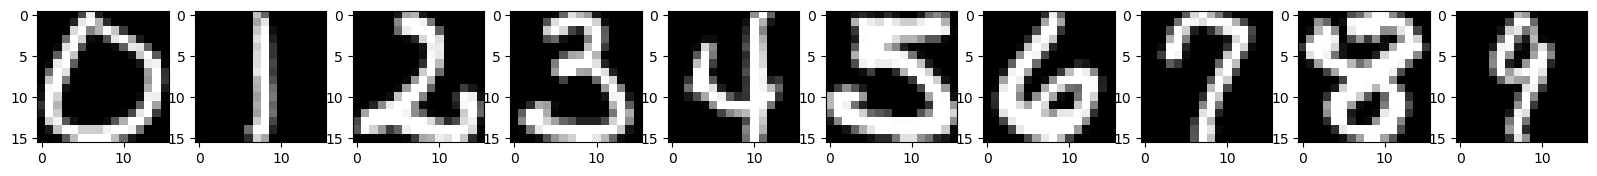

In [7]:
# Load the data
data = scipy.io.loadmat('MNIST.mat')

X = data['X']
I = data['I']

# ploting a sample picture of each number 
fig, axes = plt.subplots(1 , 10, figsize = (20,12))
for i , ax in enumerate(axes.flatten()):
    img = X[:,(I==i).ravel()]
    img = np.reshape(img[:, 0], (16, 16))
    ax.imshow(img, cmap='gray')
    
    

### classifier evaluation
evaluating the classification algorithm using SVD decomposition

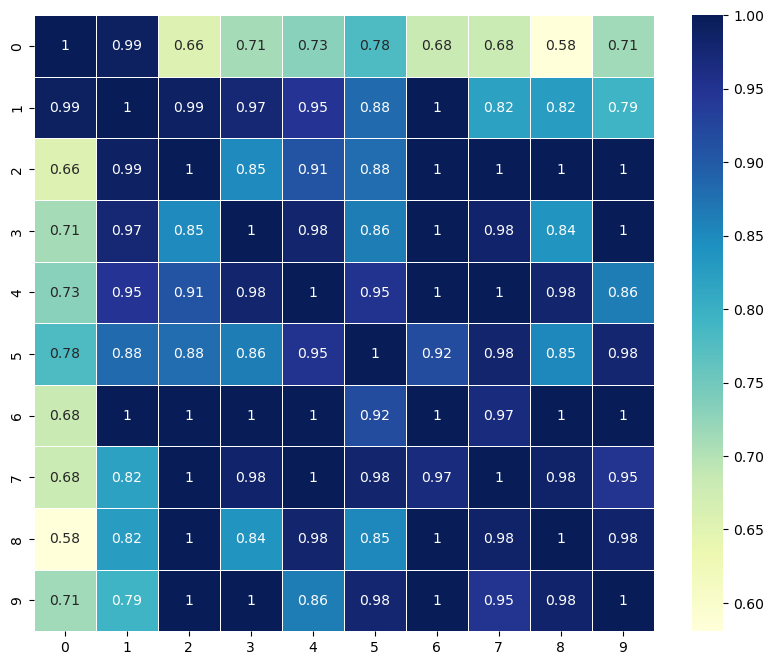

In [8]:
# create a table to test algorithm for all possible pair of two digits
res_table = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        # extracting digits equal to i and j
        X_bin = X[:,((I == i) | (I == j)).ravel()]
        I_bin = I[(I == i ) | (I == j)]
        
        # seperating data into train set and test set
        X_train , X_test , y_train , y_test = train_test_split(X_bin.T ,I_bin ,test_size=0.2, random_state=42)
        res_table[i,j] = binary_classifier([i,j], X_train.T, X_test.T, y_train, y_test)
        
# plotting the heatmap of the result
plt.figure(figsize=(10,8))
sn.heatmap(res_table, linewidths=.5, annot=True, cmap="YlGnBu")
plt.show()

### observation  
we can say that, usually if two pairs of numbers have visual similarities (like 0 and 8), the classification accuracy may goes dawn. vice versa if the similarities between to digit is low, the classification accuracy goes high.

## Ternary (3-digit) Classification
similar to the binary classification. we have to project the unknown data into three subspace and choose the class based on the minimum projection error.

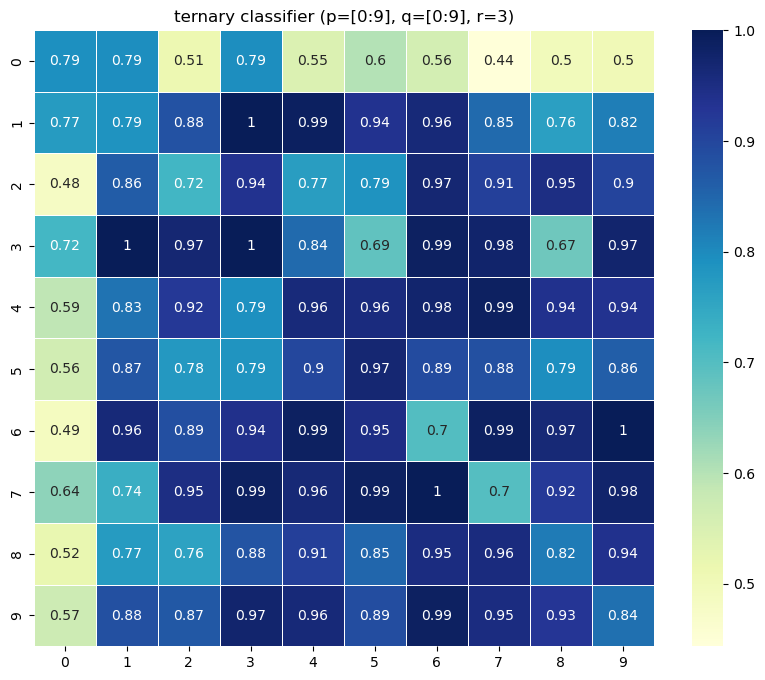

In [10]:
import numpy as np
import scipy
import random
import sklearn
import scipy.io
import matplotlib.pyplot as plt

# Load the data
data = scipy.io.loadmat('MNIST.mat')

X = data['X']
I = data['I']

res_table = np.zeros((10,10))

r = 3
for p in range(10):
    for q in range(10):
        digits = [p,q,r]
        
        # Extract the subdataset of X that contains numbers equal to digits list
        idx = list()
        for n in digits:
            tmp = np.argwhere(I == n)
            idx = idx + list(tmp[:, 1])


        # Separate training and test
        train_rate = 0.8
        train_pop = int(train_rate*len(idx))

        random.shuffle(idx)
        X_train = X[:, idx[:train_pop]]
        X_test  = X[:, idx[train_pop:]]

        I_train = I[:, idx[:train_pop]]
        I_test  = I[:, idx[train_pop:]]


        # Create the matrices X0, X1, X2
        U = list()
        for n in digits:
            tmp = np.argwhere(I_train == n)
            idx = list(tmp[:, 1])
            X_splited = X_train[:, idx]

            # Compute the SVD decomposition of X0 and X1
            u, _, _ = scipy.linalg.svd(X_splited, full_matrices=False)
            U.append(u)


        # Take a new, unknown digit for the test set.
        n_true = 0
        for i in range(len(I_test[0, :])):
            y = X_test[:, i]

            # Compute the projections of y into the two spaces
            distance = list()
            for n in range(len(digits)):
                y_orthogonal = U[n] @ (np.transpose(U[n]) @ y)

                # Compute the distances
                distance.append(np.linalg.norm((y-y_orthogonal), ord=2))

            # Assign to the predicted class
            idx = np.argwhere(distance == np.min(distance))
            I_predict = digits[idx[0, 0]]

            if I_test[0, i] == I_predict:
                n_true += 1

            # Print out
            # print('Classification Accuracy: ', (1.00*n_true)/(len(I_test[0])))
            res_table[p,q] = (1.00*n_true)/(len(I_test[0]))

# plotting the heatmap of the result
plt.figure(figsize=(10,8))
sn.heatmap(res_table, linewidths=.5, annot=True, cmap="YlGnBu")
plt.title(f'ternary classifier (p=[0:9], q=[0:9], r={r})')
plt.show()

### observation
as we can see the accuracy of the ternary classifier (here one digit is fixed and other two digits are varying) in most of the cases is worse than the binary classifier (actually it depends on the digits).  
  
**Note:** the result on the diagonal of the plot is actually binary classifier (2 digits are the same and the other is different)